# Introduction/Business Problem

The following project is aimed to find out where in the city of San Francisco would it be best to open or build a new bar for it to achieve its maximum success. We will look at what area is safest and most popular for the bar to thrive. Anyone that is looking to a open a bar in San Francisco or someone looking for a bar to visit can benefit from this analysis.

# Data Section

Public datasets from San Francisco will be used alongside Foursquare API. We will be using San Francisco Registered Business Data to help locate the number and type of business in each area, San Francisco Crime Data to observe which neighborhood is safest to establish a new bar, and Foursquare API Data for access to venue data.

# Methodology

We are going to start by importing libraries that will be necessary

In [1]:
import numpy as np # library to handle data in a vectorized manner

import requests # library to handle requests
import pandas as pd # library for data analsysis

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim

from IPython.display import Image 
from IPython.core.display import HTML

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Foursquare API credentials to access :

In [18]:
CLIENT_ID = 'PBE4VCL2GCJ3XFZ3ITJTENGSXIXBA5SZGMSR50BTFI1UD5BX'
CLIENT_SECRET = '0RGY5AAY3FT250CU2BHOU4SNUZCIZPETZCHH0SZZYFUMIZ3V'
VERSION = '20180605'

Now we are ready to upload our two San Francisco datasets. We are starting with the registered businesses.

In [12]:
business = pd.read_csv('https://data.sfgov.org/api/views/g8m3-pdis/rows.csv?accessType=DOWNLOAD')
print(business.shape)
business.head()

(260309, 36)


,Location Id,Business Account Number,Ownership Name,DBA Name,Street Address,City,State,Source Zipcode,Business Start Date,Business End Date,Location Start Date,Location End Date,Mail Address,Mail City,Mail Zipcode,Mail State,NAICS Code,NAICS Code Description,Parking Tax,Transient Occupancy Tax,LIC Code,LIC Code Description,Supervisor District,Neighborhoods - Analysis Boundaries,Business Corridor,Business Location,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,DELETE - Zip Codes,DELETE - Fire Prevention Districts,DELETE - Supervisor Districts,DELETE - Current Police Districts,DELETE - Neighborhoods,DELETE - Police Districts
0,1103593-08-161,1049564,Anjan Rajbhandari,Uber,28134 Harvey Ave,Hayward,CA,94544.0,03/24/2014,12/31/2017,03/24/2014,12/31/2017,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1218784-04-191,1100756,Luisa Alberto,High Five Sf,467 14th St,San Francisco,CA,94103.0,04/15/2019,04/15/2019,04/15/2019,04/15/2019,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,8.0,Mission,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1223199-05-191,1102424,"Sunrun, Inc.","Sunrun, Inc",595 Market St,San Francisco,CA,94105.0,06/01/2008,06/01/2008,06/01/2008,06/01/2008,NaN,NaN,NaN,NaN,2200-2299,Utilities,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1220748-05-191,1101579,Felix Hernandez,Tru-Tec Electric,44 Mcaker Ct,San Mateo,CA,94403.0,05/06/2019,06/18/2019,05/06/2019,06/18/2019,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1135452-02-171,1065102,Tirta Llc,Tirta,105 Hudson St 6s,New York City,NY,10013.0,06/09/2016,12/23/2018,06/09/2016,12/23/2018,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
#just pull the columns we need
business2 = business[['Business Start Date','DBA Name', 'Neighborhoods - Analysis Boundaries']].copy()

#drop null values
business3 = business2.dropna()

#convert business start date to datetime
business3['Business Start Date'] = business3['Business Start Date'].astype('datetime64[ns]') 

#let's just look at areas that have seen the most businesses start in the last decade.
business4 = business3.loc[business3['Business Start Date'] > '2010-01-01']

#let's also rename 'Neighborhoods - Analysis Boundaries' to just be 'Neighborhoods'
business4.rename(columns={'Neighborhoods - Analysis Boundaries': 'Neighborhood'}, inplace = True)

#let's do the same thing for the business name
business4.rename(columns={'DBA Name': 'Business Name'}, inplace = True)

business4.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Business Start Date,Business Name,Neighborhood
1,2019-04-15,High Five Sf,Mission
210,2015-01-01,Erhan Ersin,Tenderloin
233,2017-05-08,2100 Rivera,Sunset/Parkside
235,2017-06-07,Kannon Goods,Nob Hill
246,2012-03-27,Robert P Moseley,Outer Richmond


In [14]:
#Count the number of businesses in each neighborhood by grouping the data
business5 = business4.groupby('Neighborhood', as_index=False).count()
business5.reset_index()
#let's get rid of the business start date, we won't be needing it anymore
business5.drop(columns = 'Business Start Date',inplace = True)
#rename our "business name" column to "Businesses" to reflect the count per neighborhood
business5.rename(columns={'Business Name': 'Businesses'}, inplace = True)
#and sort the data
business6 = business5.sort_values(by= ['Businesses'], ascending = False).head(10)
business6.reset_index(drop=True)
business6

,Neighborhood,Businesses
5,Financial District/South Beach,12196
18,Mission,6654
33,South of Market,5759
34,Sunset/Parkside,4396
0,Bayview Hunters Point,3680
25,Outer Richmond,2909
16,Marina,2750
2,Castro/Upper Market,2690
39,West of Twin Peaks,2520
9,Hayes Valley,2520


In [15]:
#for reference, here is every neighborhood in SF as well as the count of registered businesses
business7 = business5.sort_values(by= ['Businesses'], ascending = False)
business7.reset_index(drop=True)
print(business7.shape)
business7

(41, 2)


,Neighborhood,Businesses
5,Financial District/South Beach,12196
18,Mission,6654
33,South of Market,5759
34,Sunset/Parkside,4396
0,Bayview Hunters Point,3680
25,Outer Richmond,2909
16,Marina,2750
2,Castro/Upper Market,2690
39,West of Twin Peaks,2520
9,Hayes Valley,2520


We can now plot the data to get a better idea of what is going on

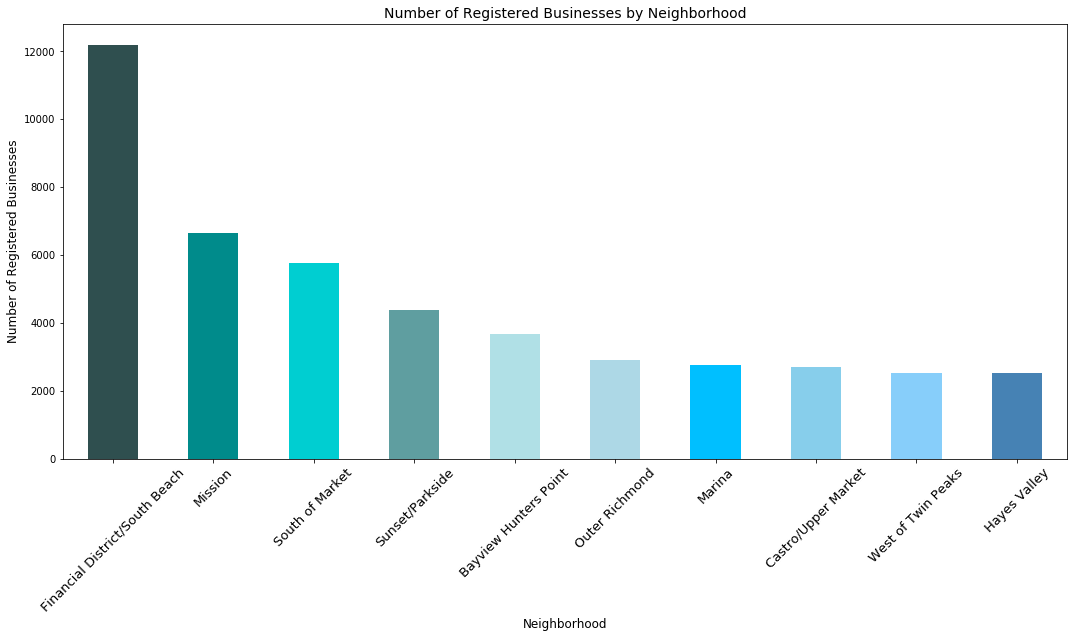

In [16]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt


business6.plot.bar(x = 'Neighborhood', y = 'Businesses', title = "Number of Registered Businesses by Neighborhood", legend = None, rot= 45, figsize = (18, 8), color=['darkslategray','darkcyan','darkturquoise','cadetblue', 'powderblue','lightblue','deepskyblue','skyblue','lightskyblue','steelblue'])
plt.ylabel('Number of Registered Businesses', fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel('Neighborhood', fontsize=12)
plt.title('Number of Registered Businesses by Neighborhood', fontsize = 14)
plt.show()

It seems like the Financial District has the most businesses, while there are still lots of other neighborhoods that run plenty of businesses. We can begin by looking at the top 10 neighborhoods.

Next, we are uploading the crime data from San Francisco to verify the safest neighborhoods in the city.

In [17]:
crime = pd.read_csv('https://data.sfgov.org/api/views/wg3w-h783/rows.csv?accessType=DOWNLOAD')
print(crime.shape)
crime.head()

(371095, 36)


,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,CAD Number,Report Type Code,Report Type Description,Filed Online,Incident Code,Incident Category,Incident Subcategory,Incident Description,Resolution,Intersection,CNN,Police District,Analysis Neighborhood,Supervisor District,Latitude,Longitude,point,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,HSOC Zones as of 2018-06-05,OWED Public Spaces,Central Market/Tenderloin Boundary Polygon - Updated,Parks Alliance CPSI (27+TL sites),ESNCAG - Boundary File,"Areas of Vulnerability, 2016"
0,2020/05/12 05:45:00 PM,2020/05/12,17:45,2020,Tuesday,2020/05/13 09:46:00 AM,92897328150,928973,206082743,NaN,II,Coplogic Initial,True,28150,Malicious Mischief,Vandalism,"Malicious Mischief, Vandalism to Property",Open or Active,NaN,NaN,Bayview,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020/05/19 09:00:00 PM,2020/05/19,21:00,2020,Tuesday,2020/05/20 05:43:00 PM,92899306244,928993,206082709,NaN,II,Coplogic Initial,True,6244,Larceny Theft,Larceny - From Vehicle,"Theft, From Locked Vehicle, >$950",Open or Active,NaN,NaN,Southern,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020/05/16 06:00:00 PM,2020/05/16,18:00,2020,Saturday,2020/05/16 10:26:00 PM,92902428150,929024,206083296,NaN,II,Coplogic Initial,True,28150,Malicious Mischief,Vandalism,"Malicious Mischief, Vandalism to Property",Open or Active,NaN,NaN,Mission,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020/03/30 12:00:00 AM,2020/03/30,00:00,2020,Monday,2020/05/04 11:47:00 AM,92905305073,929053,206062193,NaN,IS,Coplogic Supplement,True,5073,Burglary,Burglary - Other,"Burglary, Other Bldg., Unlawful Entry",Open or Active,NaN,NaN,Mission,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020/02/03 02:45:00 PM,2020/02/03,14:45,2020,Monday,2020/02/03 05:50:00 PM,89881675000,898816,200085557,200342870.0,II,Initial,NaN,75000,Missing Person,Missing Person,Found Person,Open or Active,20TH AVE \ WINSTON DR,33719000.0,Taraval,Lakeshore,7.0,37.72695,-122.476039,"(37.72694991292525, -122.47603947349434)",41.0,10.0,8.0,16.0,NaN,NaN,NaN,NaN,NaN,2.0


In [19]:
#take just the columns we need
crime1 = crime[['Analysis Neighborhood','Incident Category', 'Incident Date']]

#drop all null values
crime2 = crime1.dropna()

#convert incident date to datetime
crime2['Incident Date'] = crime2['Incident Date'].astype('datetime64[ns]') 

#filter to just crimes in the last 5 years, as the neighborhoods in san francisco are rapidly changing and being gentrified, we want data that is relevant to today's crime.
crime3 = crime2.loc[crime2['Incident Date'] > '2015-01-01']

#There's lots of scary crimes out there, but let's make sure we aren't factoring in non-criminal police reports, because that data will pollute our insights.
crime4 = crime3.loc[crime3['Incident Category'] != 'Non-Criminal']

#change the name of 'Analysis Neighborhood' to 'Neighborhood'
crime4.rename(columns={'Analysis Neighborhood': 'Neighborhood'}, inplace = True)

crime4.head(20)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Neighborhood,Incident Category,Incident Date
4,Lakeshore,Missing Person,2020-02-03
6,Mission,Stolen Property,2020-02-03
9,Pacific Heights,Miscellaneous Investigation,2020-01-05
10,Financial District/South Beach,Miscellaneous Investigation,2020-02-03
11,Castro/Upper Market,Offences Against The Family And Children,2020-01-16
13,Castro/Upper Market,Other Miscellaneous,2020-01-23
16,Twin Peaks,Lost Property,2020-01-10
17,Bayview Hunters Point,Larceny Theft,2020-02-03
18,Pacific Heights,Miscellaneous Investigation,2020-01-31
19,Pacific Heights,Larceny Theft,2020-01-31


In [20]:
#count the number of crimes in each neighborhood
crime5 = crime4.groupby('Neighborhood', as_index=False).count()
#get rid of Incident Date
crime5.drop(columns = 'Incident Date',inplace = True)
#rename our column to reflect the counts of incidents
crime5.rename(columns={'Incident Category': 'Incidents'}, inplace = True)
#and sort our values
crime6 = crime5.sort_values(by= ['Incidents'], ascending = False)
crime7 = crime6.head(10)
crime7

,Neighborhood,Incidents
18,Mission,37755
35,Tenderloin,33523
5,Financial District/South Beach,30318
33,South of Market,28171
0,Bayview Hunters Point,19822
40,Western Addition,11003
22,North Beach,10119
2,Castro/Upper Market,10100
20,Nob Hill,9694
34,Sunset/Parkside,9398


We are going to look at this data visually through a graph:

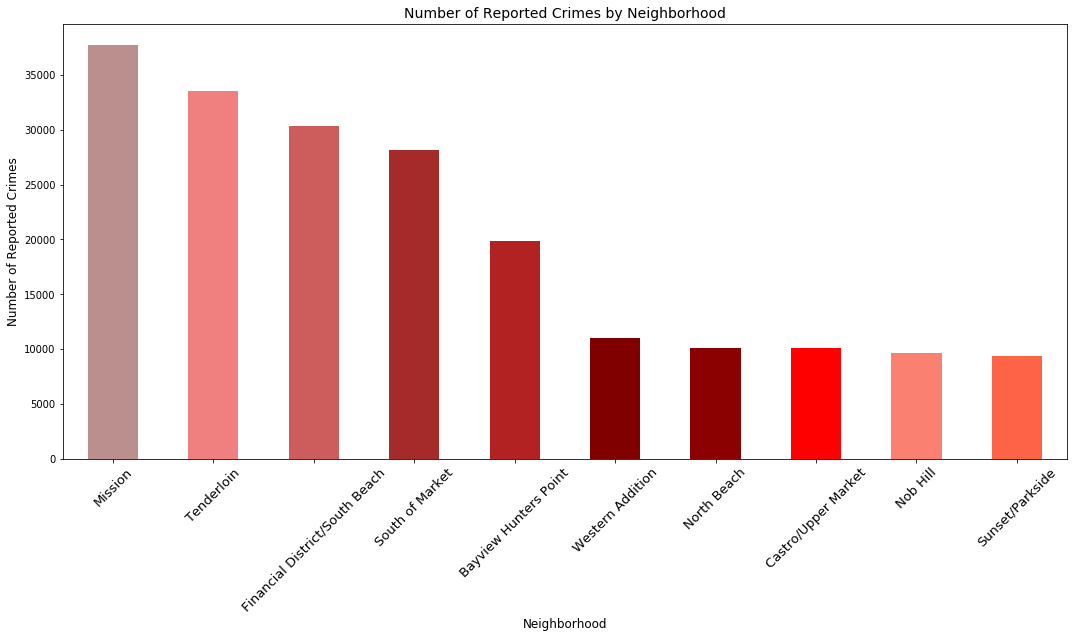

In [21]:
crime7.plot.bar(x = 'Neighborhood', y = 'Incidents', title = "Crime Incidents by Neighborhood", legend = None, rot= 45, figsize = (18, 8), color=['rosybrown', 'lightcoral', 'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red', 'salmon', 'tomato'])
plt.ylabel('Number of Reported Crimes', fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel('Neighborhood', fontsize=12)
plt.title('Number of Reported Crimes by Neighborhood', fontsize = 14)
plt.show()

After the top five neighborhoods with high crime rates, the neighborhoods seem steady.

We are going to take the top ten neighborhoods from earlier and sort it out with the neighborhoods with heavy crime rate.

In [22]:
#get a dataframe with the 5 highest incident neighborhoods
crime8 = crime7.head(5)
crime8

,Neighborhood,Incidents
18,Mission,37755
35,Tenderloin,33523
5,Financial District/South Beach,30318
33,South of Market,28171
0,Bayview Hunters Point,19822


In [23]:
'''start by merging the datasets and making a new dataset that incldues the neighborhoods 
which wereamong the top 10 for businesses AND are amond the top 5 for crime '''
Overlap = business6.merge(crime8, on=['Neighborhood'])
'''then take this joined dataframe and remove all common values from your list of top 10 
neighborhoods for businesses'''
SF_Neighborhoods = business6[(~business6.Neighborhood.isin(Overlap.Neighborhood))]
'''and what you have is the top neighborhoods for businesses that are NOT the top 
neighborhoods for crime'''
SF_Neighborhoods.head()

,Neighborhood,Businesses
34,Sunset/Parkside,4396
25,Outer Richmond,2909
16,Marina,2750
2,Castro/Upper Market,2690
39,West of Twin Peaks,2520


We are going to pull coordinates of each of our selected neighborhoods.

In [24]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="SF_explorer")
SF_Neighborhoods['Coordinates'] = SF_Neighborhoods['Neighborhood'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
SF_Neighborhoods

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Neighborhood,Businesses,Coordinates
34,Sunset/Parkside,4396,"(42.755607350000005, -81.19148009899396)"
25,Outer Richmond,2909,"(44.108805, -69.798725)"
16,Marina,2750,"(43.5139149, 16.1092196)"
2,Castro/Upper Market,2690,"(-34.6356668, -58.4193536)"
39,West of Twin Peaks,2520,"(37.75464, -122.44648)"
9,Hayes Valley,2520,"(37.7766853, -122.4229361)"


In [25]:
SF_Neighborhoods.loc[SF_Neighborhoods.Neighborhood == 'Sunset/Parkside' , 'Coordinates'] = "(37.751616, -122.490810)"
SF_Neighborhoods.loc[SF_Neighborhoods.Neighborhood == 'Outer Richmond' , 'Coordinates'] = "(37.780001, -122.490229)"
SF_Neighborhoods.loc[SF_Neighborhoods.Neighborhood == 'Castro/Upper Market' , 'Coordinates'] = "(37.762932, -122.435395)"
SF_Neighborhoods.loc[SF_Neighborhoods.Neighborhood == 'West of Twin Peaks' , 'Coordinates'] = "(37.739871, -122.460106)"
SF_Neighborhoods.loc[SF_Neighborhoods.Neighborhood == 'Marina' , 'Coordinates'] = "(37.801406, -122.439718)"
SF_Neighborhoods.loc[SF_Neighborhoods.Neighborhood == 'Hayes Valley' , 'Coordinates'] = "(37.776685, -122.422936)"
SF_Neighborhoods

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Neighborhood,Businesses,Coordinates
34,Sunset/Parkside,4396,"(37.751616, -122.490810)"
25,Outer Richmond,2909,"(37.780001, -122.490229)"
16,Marina,2750,"(37.801406, -122.439718)"
2,Castro/Upper Market,2690,"(37.762932, -122.435395)"
39,West of Twin Peaks,2520,"(37.739871, -122.460106)"
9,Hayes Valley,2520,"(37.776685, -122.422936)"


### We can now merge our datasets

In [27]:
SF = SF_Neighborhoods.merge(crime6, on=['Neighborhood'])
SF.rename(columns={'Incidents':'Crimes'}, inplace = True)
SF = SF[['Neighborhood', 'Businesses', 'Crimes','Coordinates']]
SF['Coordinates'].to_string()
SF[['Latitude','Longitude']] = SF['Coordinates'].str.strip('(').str.strip(')').str.split(', ', expand=True)

SF

,Neighborhood,Businesses,Crimes,Coordinates,Latitude,Longitude
0,Sunset/Parkside,4396,9398,"(37.751616, -122.490810)",37.751616,-122.490810
1,Outer Richmond,2909,7351,"(37.780001, -122.490229)",37.780001,-122.490229
2,Marina,2750,8193,"(37.801406, -122.439718)",37.801406,-122.439718
3,Castro/Upper Market,2690,10100,"(37.762932, -122.435395)",37.762932,-122.435395
4,West of Twin Peaks,2520,6594,"(37.739871, -122.460106)",37.739871,-122.460106
5,Hayes Valley,2520,9281,"(37.776685, -122.422936)",37.776685,-122.422936


## Foursquare Data Analysis

We can use Foursquare API to search for the most popular venues near our neighborhoods.

In [59]:
def getNearbyVenues(names, latitudes, longitudes, radius=800, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [60]:
SF_venues = getNearbyVenues(names=SF['Neighborhood'],
                                   latitudes=SF['Latitude'],
                                   longitudes=SF['Longitude']
                                  )

Sunset/Parkside
Outer Richmond
Marina
Castro/Upper Market
West of Twin Peaks
Hayes Valley


In [34]:
print(SF_venues.shape)
SF_venues.head()

(472, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Sunset/Parkside,37.751616,-122.490810,TJ Brewed Tea and Real Fruit (TJ Cups),37.753561,-122.490028,Bubble Tea Shop
1,Sunset/Parkside,37.751616,-122.490810,S&T Hong Kong Seafood,37.753702,-122.491278,Dim Sum Restaurant
2,Sunset/Parkside,37.751616,-122.490810,Donut Time,37.753651,-122.489439,Donut Shop
3,Sunset/Parkside,37.751616,-122.490810,Polly Ann Ice Cream,37.753454,-122.497765,Ice Cream Shop
4,Sunset/Parkside,37.751616,-122.490810,Sunset Recreation Center,37.757310,-122.487072,Playground


In [35]:
#take a look at how many venues were pulled for each neighborhood
SF_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Castro/Upper Market,100,100,100,100,100,100
Hayes Valley,100,100,100,100,100,100
Marina,100,100,100,100,100,100
Outer Richmond,89,89,89,89,89,89
Sunset/Parkside,32,32,32,32,32,32
West of Twin Peaks,51,51,51,51,51,51


In [36]:
#the number of unique types of venues pulled
print('There are {} uniques categories.'.format(len(SF_venues['Venue Category'].unique())))

There are 169 uniques categories.


We are going to graph the most common venue types in our 6 favorite neighborhoods:

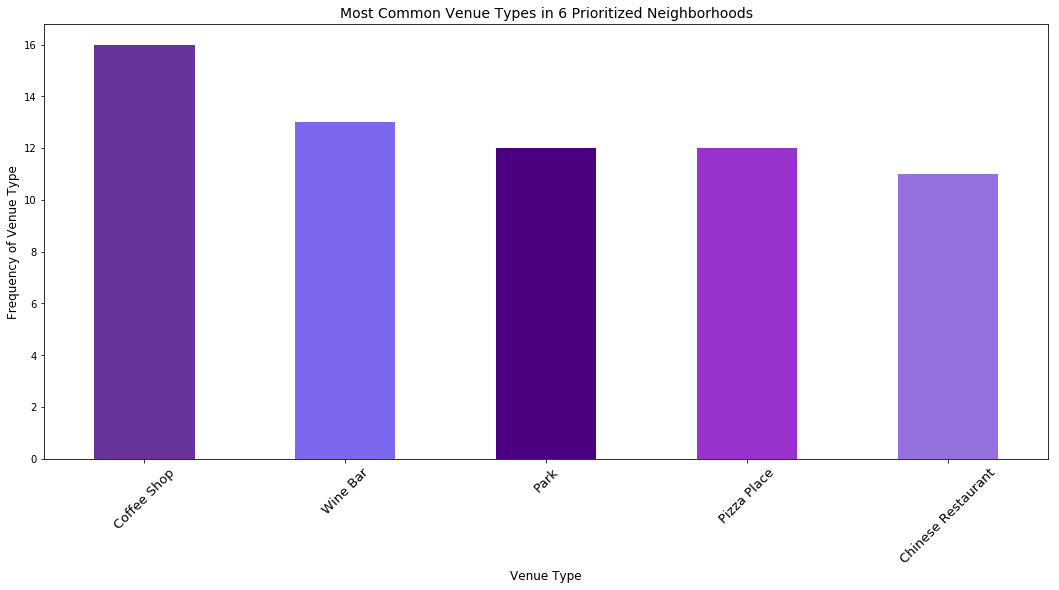

In [37]:
SF_top_venues = SF_venues.groupby('Venue Category', as_index = False).count().sort_values('Neighborhood', ascending = False).head(5)
SF_top_venues = SF_top_venues[['Venue Category','Neighborhood']]
SF_top_venues.rename(columns={'Neighborhood': 'Frequency'}, inplace = True)
SF_top_venues.plot.bar(x='Venue Category', y='Frequency', legend = None, title = "Most common venue types in 6 prioritized neighborhoods", rot= 45, figsize = (18, 8), color=['rebeccapurple','mediumslateblue','indigo','darkorchid','mediumpurple'])
plt.ylabel('Frequency of Venue Type', fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel('Venue Type', fontsize=12)
plt.title('Most Common Venue Types in 6 Prioritized Neighborhoods', fontsize = 14)
plt.show()

Coffee shops seem to be the most common venue type, followed by a wine bar. This gives us a good insight that maybe we should open a wine bar since it is a bar we are looking into.

With hot encoding we can further analyze results

In [38]:
# one hot encoding
SF_onehot = pd.get_dummies(SF_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
SF_onehot['Neighborhood'] = SF_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [SF_onehot.columns[-1]] + list(SF_onehot.columns[:-1])
SF_onehot = SF_onehot[fixed_columns]

SF_onehot.head()

,Neighborhood,Accessories Store,Alternative Healer,American Restaurant,Antique Shop,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beer Bar,Beer Garden,Bike Shop,Board Shop,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Stop,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Chinese Restaurant,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store,Elementary School,Event Space,Farmers Market,Field,Flea Market,Flower Shop,Food & Drink Shop,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gastropub,Gay Bar,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Hill,Historic Site,History Museum,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Liquor Store,Lounge,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle School,Monument / Landmark,Moroccan Restaurant,Motel,Mountain,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Noodle House,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Park,Pedestrian Plaza,Performing Arts Venue,Pet Café,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Ramen Restaurant,Record Shop,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Trail,Tree,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Sunset/Parkside,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Sunset/Parkside,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Sunset/Parkside,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Sunset/Parkside,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Sunset/Parkside,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [39]:
#examine shape of new dataframe
SF_onehot.shape

(472, 170)

In [40]:
#now group the data
SF_grouped = SF_onehot.groupby('Neighborhood').mean().reset_index()
print(SF_grouped.shape)
SF_grouped

(6, 170)


,Neighborhood,Accessories Store,Alternative Healer,American Restaurant,Antique Shop,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beer Bar,Beer Garden,Bike Shop,Board Shop,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Stop,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Chinese Restaurant,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store,Elementary School,Event Space,Farmers Market,Field,Flea Market,Flower Shop,Food & Drink Shop,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gastropub,Gay Bar,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Hill,Historic Site,History Museum,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Liquor Store,Lounge,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle School,Monument / Landmark,Moroccan Restaurant,Motel,Mountain,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Noodle House,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Park,Pedestrian Plaza,Performing Arts Venue,Pet Café,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Ramen Restaurant,Record Shop,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Trail,Tree,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Castro/Upper Market,0.00,0.00,0.010000,0.000000,0.01,0.01,0.01,0.00,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.00000,0.00,0.00,0.00,0.000000,0.010000,0.00,0.000000,0.01,0.01000,0.010000,0.010000,0.000000,0.000000,0.00000,0.000000,0.00,0.010000,0.01,0.01,0.000000,0.000000,0.00,0.00,0.00,0.060000,0.00,0.00,0.01,0.000000,0.000000,0.000000,0.00,0.01,0.01,0.020000,0.020000,0.000000,0.010000,0.000000,0.02,0.00000,0.010000,0.00,0.0000,0.00,0.01,0.00000,0.000000,0.01,0.00,0.01,0.000000,0.00,0.01,0.00,0.09,0.00,0.00,0.000000,0.000000,0.020000,0.010000,0.010000,0.00000,0.00,0.02,0.01,0.01,0.01,0.00,0.01000,0.030000,0.01,0.010000,0.020000,0.00,0.02,0.00,0.00,0.000000,0.01,0.010000,0.00,0.00,0.020000,0.010000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.01,0.00,0.000000,0.00,0.000000,0.040000,0.00,0.000000,0.00,0.01,0.00,0.00,0.040000,0.00,0.00,0.00,0.02,0.000000,0.01,0.020000,0.000000,0.01,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.010000,0.01,0.01,0.020000,0.000000,0.000000,0.000000,0.00,0.00,0.01,0.000000,0.00,0.00,0.01,0.000000,0.01,0.00,0.000000,0.000000,0.00,0.030000,0.00,0.000000,0.000000,0.000000,0.010000,0.000000,0.00,0.000000,0.020000,0.01,0.01
1,Hayes Valley,0.01,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.01,0.030000,0.000000,0.010000,0.00000,0.01,0.01,0.00,0.000000,0.010000,0.03,0.000000,0.00,0.00000,0.020000,0.010000,0.000000,0.000000,0.00000,0.000000,0.01,0.020000,0.01,0.00,0.000000,0.000000,0.01,0.02,0.03,0.030000,0.01,0.01,0.02,0.000000,0.000000,0.000000,0.00,0.00,0.01,0.000000,0.030000,0.000000,0.000000,0.000000,0.00,0.01000,0.000000,0.00,0.0000,0.

In [41]:
#print each neighborhood with the top 5 most common venues
num_top_venues = 5

for hood in SF_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = SF_grouped[SF_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Castro/Upper Market----
                     venue  freq
0                  Gay Bar  0.09
1              Coffee Shop  0.06
2                     Park  0.04
3  New American Restaurant  0.04
4          Thai Restaurant  0.03


----Hayes Valley----
               venue  freq
0           Wine Bar  0.05
1             Bakery  0.03
2        Coffee Shop  0.03
3       Dessert Shop  0.03
4  French Restaurant  0.03


----Marina----
                  venue  freq
0  Gym / Fitness Center  0.05
1    Italian Restaurant  0.04
2              Wine Bar  0.04
3     French Restaurant  0.04
4        Cosmetics Shop  0.04


----Outer Richmond----
                venue  freq
0  Chinese Restaurant  0.08
1                Café  0.04
2     Thai Restaurant  0.03
3  Seafood Restaurant  0.03
4   Korean Restaurant  0.03


----Sunset/Parkside----
                 venue  freq
0   Chinese Restaurant  0.12
1  Japanese Restaurant  0.06
2    Elementary School  0.06
3           Playground  0.06
4   Dim Sum Restaurant  0.06

We can now place our data into a dataframe of the most popular venues for each neighborhood

In [42]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [43]:
num_top_venues = 30

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = SF_grouped['Neighborhood']

for ind in np.arange(SF_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(SF_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue
0,Castro/Upper Market,Gay Bar,Coffee Shop,Park,New American Restaurant,Thai Restaurant,Indian Restaurant,Japanese Restaurant,Bakery,Dessert Shop,Juice Bar,Dog Run,Pet Store,Deli / Bodega,Mediterranean Restaurant,Seafood Restaurant,Hill,Grocery Store,Pizza Place,Wine Bar,Museum,Cycle Studio,Dance Studio,Mexican Restaurant,Liquor Store,Candy Store,Camera Store,Concert Hall,Yoga Studio,Latin American Restaurant,Diner
1,Hayes Valley,Wine Bar,Pizza Place,New American Restaurant,Bakery,Dessert Shop,Coffee Shop,Cocktail Bar,Boutique,Theater,French Restaurant,Optical Shop,Café,Clothing Store,Sushi Restaurant,Bubble Tea Shop,Food & Drink Shop,Concert Hall,Performing Arts Venue,Ice Cream Shop,Park,Juice Bar,Jazz Club,Italian Restaurant,Yoga Studio,Kids Store,Liquor Store,Gym / Fitness Center,Lounge,Massage Studio,Mexican Restaurant
2,Marina,Gym / Fitness Center,Cosmetics Shop,Wine Bar,Italian Restaurant,French Restaurant,Park,Sandwich Place,Salad Place,Deli / Bodega,Diner,Electronics Store,Gym,Coffee Shop,Playground,Juice Bar,Mexican Restaurant,Ice Cream Shop,New American Restaurant,Sushi Restaurant,Thai Restaurant,Taco Place,American Restaurant,Asian Restaurant,Historic Site,Wine Shop,Bakery,Athletics & Sports,Indian Restaurant,Clothing Store,Health & Beauty Service
3,Outer Richmond,Chinese Restaurant,Café,Sushi Restaurant,Playground,Vietnamese Restaurant,Korean Restaurant,Seafood Restaurant,Thai Restaurant,Japanese Restaurant,Sandwich Place,Pizza Place,Burger Joint,Burrito Place,Indian Restaurant,Dessert Shop,Bakery,Liquor Store,Restaurant,Deli / Bodega,Moroccan Restaurant,Coffee Shop,Pharmacy,Diner,Mexican Restaurant,Creperie,Dim Sum Restaurant,Ramen Restaurant,Noodle House,Movie Theater,Burmese Restaurant
4,Sunset/Parkside,Chinese Restaurant,Japanese Restaurant,Elementary School,Dim Sum Restaurant,Playground,Pharmacy,Pizza Place,Bus Line,Sandwich Place,Bus Stop,Pool,Dessert Shop,Coffee Shop,Brewery,Donut Shop,Middle School,Field,Ice Cream Shop,Gym,Bubble Tea Shop,Hardware Store,Bar,Vietnamese Restaurant,Baseball Field,Bank,Dog Run,Asian Restaurant,Dive Bar,Dumpling Restaurant,Electronics Store
5,West of Twin Peaks,Burger Joint,Pizza Place,Park,Sandwich Place,Italian Restaurant,Mexican Restaurant,Coffee Shop,Wine Bar,Pharmacy,Bus Stop,Pub,Burrito Place,Monument / Landmark,Mediterranean Restaurant,Diner,Café,Playground,Brazilian Restaurant,Shipping Store,Bookstore,Indian Restaurant,Movie Theater,Gym / Fitness Center,Thai Restaurant,Music Store,Greek Restaurant,Tree,Grocery Store,Toy / Game Store,Gym


## Clustering with K means

In [44]:
# set number of clusters
kclusters = 3

SF_grouped_clustering = SF_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(SF_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 2, 0, 1], dtype=int32)

Creating a dataframe that includes cluster and top 10 venues for each neighborhood

In [52]:
SF_merged = SF

In [53]:
# merge SF_grouped with SF_data to add latitude/longitude for each neighborhood
SF_merged = SF_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [54]:
#also including the number of bars and restaurants that each neighborhood has in its top 10 most popular spots.
SF_merged["Bars and Restaurants"] = ""
SF_merged.loc[SF_merged.Neighborhood == 'Sunset/Parkside', 'Bars and Restaurants'] = .37
SF_merged.loc[SF_merged.Neighborhood == 'Outer Richmond', 'Bars and Restaurants'] = .6
SF_merged.loc[SF_merged.Neighborhood == 'Marina', 'Bars and Restaurants'] = .67
SF_merged.loc[SF_merged.Neighborhood == 'Castro/Upper Market', 'Bars and Restaurants'] = .37
SF_merged.loc[SF_merged.Neighborhood == 'West of Twin Peaks', 'Bars and Restaurants'] = .5
SF_merged.loc[SF_merged.Neighborhood == 'Hayes Valley', 'Bars and Restaurants'] = .5
SF_merged['Bars and Restaurants'].astype(int, inplace = True)

0    0
1    0
2    0
3    0
4    0
5    0
Name: Bars and Restaurants, dtype: int64

In [55]:
SF_merged['Latitude'] = SF_merged['Latitude'].astype(float)
SF_merged['Longitude'] = SF_merged['Longitude'].astype(float)
SF_merged['Cluster Labels'] = SF_merged['Cluster Labels'].astype(int)



SF_merged

,Neighborhood,Businesses,Crimes,Coordinates,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,Bars and Restaurants
0,Sunset/Parkside,4396,9398,"(37.751616, -122.490810)",37.751616,-122.490810,0,Chinese Restaurant,Japanese Restaurant,Elementary School,Dim Sum Restaurant,Playground,Pharmacy,Pizza Place,Bus Line,Sandwich Place,Bus Stop,Pool,Dessert Shop,Coffee Shop,Brewery,Donut Shop,Middle School,Field,Ice Cream Shop,Gym,Bubble Tea Shop,Hardware Store,Bar,Vietnamese Restaurant,Baseball Field,Bank,Dog Run,Asian Restaurant,Dive Bar,Dumpling Restaurant,Electronics Store,0.37
1,Outer Richmond,2909,7351,"(37.780001, -122.490229)",37.780001,-122.490229,2,Chinese Restaurant,Café,Sushi Restaurant,Playground,Vietnamese Restaurant,Korean Restaurant,Seafood Restaurant,Thai Restaurant,Japanese Restaurant,Sandwich Place,Pizza Place,Burger Joint,Burrito Place,Indian Restaurant,Dessert Shop,Bakery,Liquor Store,Restaurant,Deli / Bodega,Moroccan Restaurant,Coffee Shop,Pharmacy,Diner,Mexican Restaurant,Creperie,Dim Sum Restaurant,Ramen Restaurant,Noodle House,Movie Theater,Burmese Restaurant,0.6
2,Marina,2750,8193,"(37.801406, -122.439718)",37.801406,-122.439718,1,Gym / Fitness Center,Cosmetics Shop,Wine Bar,Italian Restaurant,French Restaurant,Park,Sandwich Place,Salad Place,Deli / Bodega,Diner,Electronics Store,Gym,Coffee Shop,Playground,Juice Bar,Mexican Restaurant,Ice Cream Shop,New American Restaurant,Sushi Restaurant,Thai Restaurant,Taco Place,American Restaurant,Asian Restaurant,Historic Site,Wine Shop,Bakery,Athletics & Sports,Indian Restaurant,Clothing Store,Health & Beauty Service,0.67
3,Castro/Upper Market,2690,10100,"(37.762932, -122.435395)",37.762932,-122.435395,1,Gay Bar,Coffee Shop,Park,New American Restaurant,Thai Restaurant,Indian Restaurant,Japanese Restaurant,Bakery,Dessert Shop,Juice Bar,Dog Run,Pet Store,Deli / Bodega,Mediterranean Restaurant,Seafood Restaurant,Hill,Grocery Store,Pizza Place,Wine Bar,Museum,Cycle Studio,Dance Studio,Mexican Restaurant,Liquor Store,Candy Store,Camera Store,Concert Hall,Yoga Studio,Latin American Restaurant,Diner,0.37
4,West of Twin Peaks,2520,6594,"(37.739871, -122.460106)",37.739871,-122.460106,1,Burger Joint,Pizza Place,Park,Sandwich Place,Italian Restaurant,Mexican Restaurant,Coffee Shop,Wine Bar,Pharmacy,Bus Stop,Pub,Burrito Place,Monument / Landmark,Mediterranean Restaurant,Diner,Café,Playground,Brazilian Restaurant,Shipping Store,Bookstore,Indian Restaurant,Movie Theater,Gym / Fitness Center,Thai Restaurant,Music Store,Greek Restaurant,Tree,Grocery Store,Toy / Game Store,Gym,0.5
5,Hayes Valley,2520,9281,"(37.776685, -122.422936)",37.776685,-122.422936,1,Wine Bar,Pizza Place,New American Restaurant,Bakery,Dessert Shop,Coffee Shop,Cocktail Bar,Boutique,Theater,French Restaurant,Optical Shop,Café,Clothing Store,Sushi Restaurant,Bubble Tea Shop,Food & Drink Shop,Concert Hall,Performing Arts Venue,Ice Cream Shop,Park,Juice Bar,Jazz Club,Italian Restaurant,Yoga Studio,Kids Store,Liquor Store,Gym / Fitness Center,Lounge,Massage Studio,Mexican Restaurant,0.5


We can visualize the percentage of popular venues in each neighborhood that are bars/restaurants in order to identify popular neighborhoods due to these bars/restaurants.

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


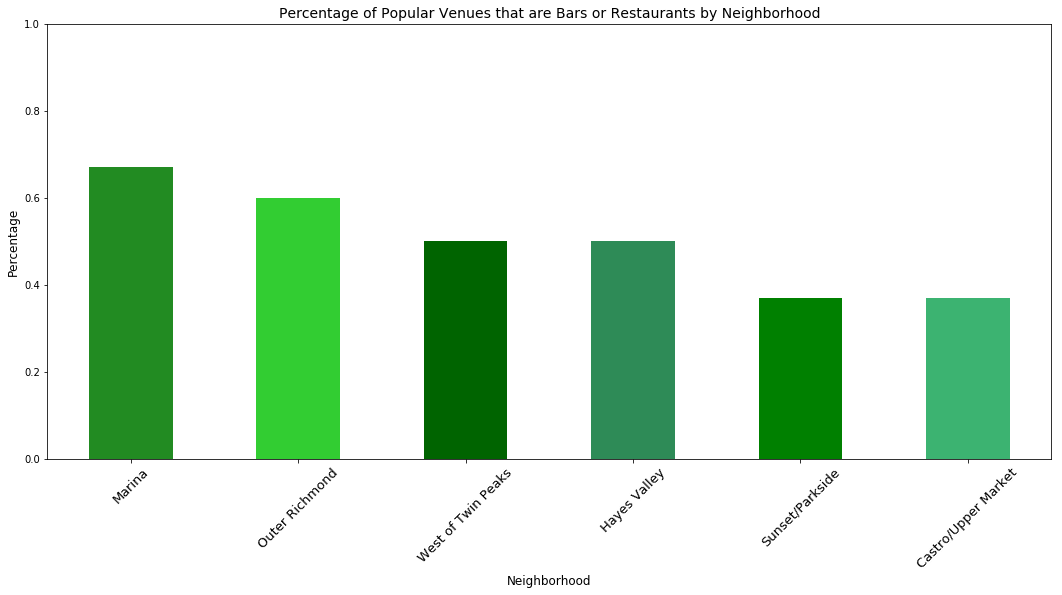

In [56]:
SF_rb = SF_merged[['Neighborhood','Bars and Restaurants']]
SF_rb.rename(columns={'Bars and Restaurants': 'Frequency'}, inplace = True)
SF_rb.sort_values('Frequency', inplace = True, ascending = False)
SF_rb.plot.bar(x='Neighborhood',y ='Frequency', rot = 45, figsize = (18, 8), legend = None, color = ['forestgreen','limegreen','darkgreen','seagreen','green','mediumseagreen'])
plt.ylabel('Percentage', fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel('Neighborhood', fontsize=12)
plt.ylim(0,1)
plt.title('Percentage of Popular Venues that are Bars or Restaurants by Neighborhood', fontsize = 14)
plt.show()

## Map Clustered Neighborhoods

We are going to build a map of San Francisco

In [57]:
address = 'San Francisco, California'

geolocator = Nominatim(user_agent="SF_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of San Francisco are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of San Francisco are 37.7790262, -122.4199061.


In [58]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(.7, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# # add markers to the map
markers_colors = []
for lat, lon, poi, cluster, bars in zip(SF_merged['Latitude'], SF_merged['Longitude'], SF_merged['Neighborhood'], SF_merged['Cluster Labels'], SF_merged['Bars and Restaurants']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=35*bars,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

# Results and Discussion

By using information from datasets of business registrations and crime rates, as well as Foursquare, we have narrowed down neighborhood options to open up a bar in one of six areas in San Francisco

The most common venues in our areas of interest were discovered to be coffee shops, wine bars, parks, pizza places, and Chinese restaurants.

Clustering neighborhoods based on their most popular venues grouped West of Twin Peaks alongside with Castro, Hayes Valley, and Marine. Meanwhile, outer Richmond was placed in its own cluster as was Sunset.

Castro and Hayes Valley are the two neighborhoods where bars are the most popular venues.

Because Castro is the neighborhood that has the most crime rates out of the six areas we looked at, I have come to the conclusion that Hayes Valley is the neighborhood where a new bar should be opened because it is the 3rd out of 6 in crime rates and has much of a bar scene. 

# Conclusion

This data science project used python libraries to manipulate and transform datasets and Foursquare API to explore the neighborhoods of San Francisco. Folium map was used for clustering and segmenting the neighborhoods. These analytical tools allow for in depth analysis and problem solving as seen in this case. With public data of San Francisco alongside with the libraries I was able to make an educated choice on where I believe is the optimal neighborhood to open a bar in San Francisco. 